# Mushroom Data Set

In [109]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('mushrooms.csv')

print(data.shape)

data.head()

(8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


# Decision Tree with sklearn

In [185]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import tree

from IPython.display import Image
import pandas as pd
import numpy as np
import pydotplus
import os

data = pd.read_csv('mushrooms.csv')

X = data.iloc[:,1:]
y = data['class']

le = preprocessing.LabelEncoder()

trans_data = []
for col in range(len(X.columns)):
    le.fit(X.iloc[:,col])
    transformed_data = le.transform(X.iloc[:,col]) 
    trans_data.append(transformed_data)

trans_data = np.array(trans_data)
trans_data = trans_data.transpose()
X = trans_data

le.fit(y)
target_data = le.transform(y) 
y = target_data

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

In [186]:
dt_clf = DecisionTreeClassifier(criterion='entropy',max_depth=7)
dt_clf = dt_clf.fit(X_train, y_train)
dt_prediction = dt_clf.predict(X_test)

In [187]:
feature_names = data.columns.tolist()[1:]
target_names = ['edible','poison']

In [188]:
dt_dot_data = tree.export_graphviz(dt_clf, out_file = None,
                                  feature_names = feature_names,
                                  class_names = target_names,
                                  filled = True, rounded = True,
                                  special_characters = True)
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)
image = Image(dt_graph.create_png())

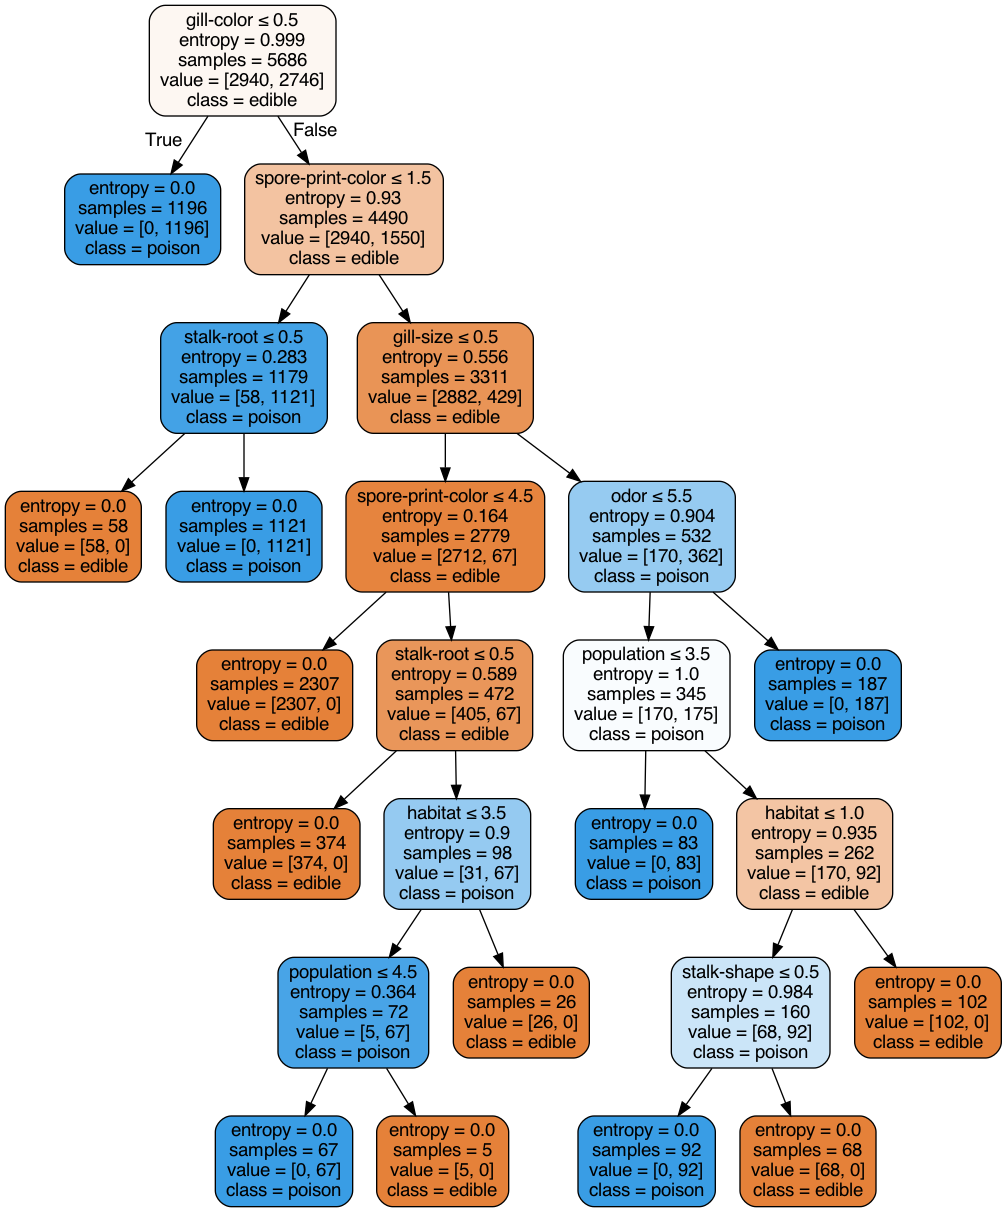

In [189]:
image

In [190]:
cm = confusion_matrix(dt_prediction,y_test)
cm

array([[1268,    0],
       [   0, 1170]])

In [191]:
accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
accuracy

1.0

# Decision tree from Githup

In [278]:
# from __future__ import print_function 
import numpy as np 
import pandas as pd 


class TreeNode(object):
    def __init__(self, ids = None, children = [], entropy = 0, depth = 0):
        self.ids = ids           # index of data in this node
        self.entropy = entropy   # entropy, will fill later
        self.depth = depth       # distance to root node
        self.split_attribute = None # which attribute is chosen, it non-leaf
        self.children = children # list of its child nodes
        self.order = None       # order of values of split_attribute in children
        self.label = None       # label of node if it is a leaf

    def set_properties(self, split_attribute, order):
        self.split_attribute = split_attribute
        self.order = order

    def set_label(self, label):
        self.label = label


def entropy(freq):
    # remove prob 0 
    freq_0 = freq[np.array(freq).nonzero()[0]]
    prob_0 = freq_0/float(freq_0.sum())
    return -np.sum(prob_0*np.log(prob_0))

class DecisionTreeID3(object):
    def __init__(self, max_depth= 10, min_samples_split = 2, min_gain = 1e-4):
        self.root = None
        self.max_depth = max_depth 
        self.min_samples_split = min_samples_split 
        self.Ntrain = 0
        self.min_gain = min_gain
    
    def fit(self, data, target):
        self.Ntrain = data.count()[0]
        self.data = data 
        self.attributes = list(data)
        self.target = target 
        self.labels = target.unique()
        
        ids = range(self.Ntrain)
        self.root = TreeNode(ids = ids, entropy = self._entropy(ids), depth = 0)
        queue = [self.root]
        while queue:
            node = queue.pop()
            if node.depth < self.max_depth or node.entropy < self.min_gain:
                node.children = self._split(node)
                if not node.children: #leaf node
                    self._set_label(node)
                queue += node.children
            else:
                self._set_label(node)
                
    def _entropy(self, ids):
        # calculate entropy of a node with index ids
        if len(ids) == 0: return 0
        ids = [i for i in ids] # panda series index starts from 1
        freq = np.array(self.target[ids].value_counts())
        return entropy(freq)

    def _set_label(self, node):
        # find label for a node if it is a leaf
        # simply chose by major voting 
        target_ids = [i for i in node.ids]  # target is a series variable
        node.set_label(self.target[target_ids].mode()[0]) # most frequent label
    
    def _split(self, node):
        ids = node.ids 
        best_gain = 0
        best_splits = []
        best_attribute = None
        order = None
        sub_data = self.data.iloc[ids, :]
        for i, att in enumerate(self.attributes):
            values = self.data.iloc[ids, i].unique().tolist()
            if len(values) == 1: continue # entropy = 0
            splits = []
            for val in values: 
                sub_ids = sub_data.index[sub_data[att] == val].tolist()
                splits.append([sub_id for sub_id in sub_ids])
            # don't split if a node has too small number of points
            if min(map(len, splits)) < self.min_samples_split: continue
            # information gain
            HxS= 0
            for split in splits:
                HxS += len(split)*self._entropy(split)/len(ids)
            gain = node.entropy - HxS 
            if gain < self.min_gain: continue # stop if small gain 
            if gain > best_gain:
                best_gain = gain 
                best_splits = splits
                best_attribute = att
                order = values
        node.set_properties(best_attribute, order)
        child_nodes = [TreeNode(ids = split,
                     entropy = self._entropy(split), depth = node.depth + 1) for split in best_splits]
        return child_nodes

    def predict(self, new_data):
        """
        :param new_data: a new dataframe, each row is a datapoint
        :return: predicted labels for each row
        """
        npoints = new_data.count()[0]
        labels = [None]*npoints
        for n in range(npoints):
            x = new_data.iloc[n, :] # one point 
            # start from root and recursively travel if not meet a leaf 
            node = self.root
            while node.children: 
                node = node.children[node.order.index(x[node.split_attribute])]
            labels[n] = node.label
            
        return labels


In [279]:
import pandas as pd
import numpy as np
import math 
import statistics 
import copy

from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

data = pd.read_csv('mushrooms.csv')

X = data.iloc[:,1:]
y = data['class']

le = preprocessing.LabelEncoder()

trans_data = []
for col in range(len(X.columns)):
    le.fit(X.iloc[:,col])
    transformed_data = le.transform(X.iloc[:,col]) 
    trans_data.append(transformed_data)

trans_data = np.array(trans_data)
trans_data = trans_data.transpose()
X = trans_data
X = pd.DataFrame(X, columns=data.columns[1:])

le.fit(y)
target_data = le.transform(y) 
y = target_data

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_train = X_train.reset_index()
X_train = X_train.iloc[:,1:]

X_test = pd.DataFrame(X_test, columns=X.columns)
X_test = X_test.reset_index()
X_test = X_test.iloc[:,1:]

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [280]:
tree = DecisionTreeID3(max_depth = 5, min_samples_split = 2)

tree.fit(X_train, y_train)

predict_y = tree.predict(X_test)

conf_matx = confusion_matrix(y_test, predict_y)

conf_matx

array([[1255,    0],
       [   0, 1183]])

In [281]:
accuracy = (conf_matx[0][0] + conf_matx[1][1]) / conf_matx.sum()
accuracy

1.0

In [282]:
root = tree.root

In [283]:
root.split_attribute

'odor'

In [285]:
node_l = [root]
while node_l: 
    print('node depth : ',node.depth)
    print('parent node children num : ', len(node.children))
    print('node split attribute : ', node.split_attribute)
    print('node entropy : ', node.entropy)
    print('=============children=============')
    for c in node.children:
        if c.order:
            node_l.append(c)
            print(c.order)
        else:
            print('entropy : ', c.entropy, 'label : ', c.label)
    
    node = node_l.pop()
    print()

node depth :  0
parent node children num :  9
node split attribute :  odor
node entropy :  0.6923984767112593
=============children=============
entropy :  -0.0 label :  1
[2, 3, 4, 7, 5, 8, 0, 1]
entropy :  -0.0 label :  1
entropy :  -0.0 label :  0
entropy :  -0.0 label :  1
entropy :  -0.0 label :  1
entropy :  -0.0 label :  0
entropy :  -0.0 label :  1
entropy :  -0.0 label :  1

node depth :  1
parent node children num :  8
node split attribute :  spore-print-color
node entropy :  0.14219302328166022
=============children=============
entropy :  -0.0 label :  0
entropy :  -0.0 label :  0
entropy :  -0.0 label :  0
[1, 6, 0, 2, 4]
entropy :  -0.0 label :  1
entropy :  -0.0 label :  0
entropy :  -0.0 label :  0
entropy :  -0.0 label :  0

node depth :  2
parent node children num :  5
node split attribute :  habitat
node entropy :  0.24134896566342398
=============children=============
entropy :  -0.0 label :  0
entropy :  -0.0 label :  0
[1, 0]
[1, 4, 8, 9]
entropy :  -0.0 label :  